In [10]:
# AI vs Real Image Classifier - Full Inference & Confusion Matrix

import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from train import SimpleCNN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [11]:
# ------------------------
# Configuration
# ------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = 'models/cnn_model.pth'
test_dir = 'data/test/'  # must have FAKE and REAL subfolders

class_names = ['FAKE', 'REAL']

In [12]:
# ------------------------
# Load Model
# ------------------------
model = SimpleCNN().to(device)
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (

In [13]:
# ------------------------
# Image Transform
# ------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [14]:
# ------------------------
# Inference Function
# ------------------------
def predict_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(img_t)
    label_idx = int(pred.item() > 0.5)
    return label_idx, pred.item(), img

In [15]:
# ------------------------
# Loop through test images
# ------------------------
y_true = []
y_pred = []

samples_to_plot = []

for label_idx, label in enumerate(class_names):
    folder = os.path.join(test_dir, label)
    files = os.listdir(folder)
    for f in files:
        img_path = os.path.join(folder, f)
        pred_idx, score, img = predict_image(img_path)
        y_true.append(label_idx)
        y_pred.append(pred_idx)
        # store first 3 of each class for plotting
        if len(samples_to_plot) < 6:
            samples_to_plot.append((img, class_names[pred_idx], score))

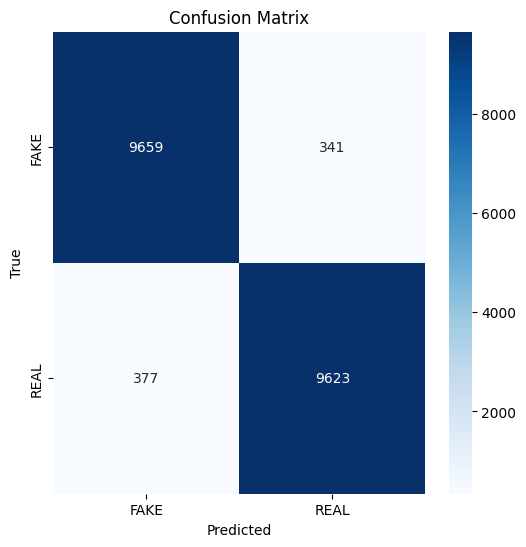

In [16]:
# ------------------------
# Confusion Matrix
# ------------------------
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

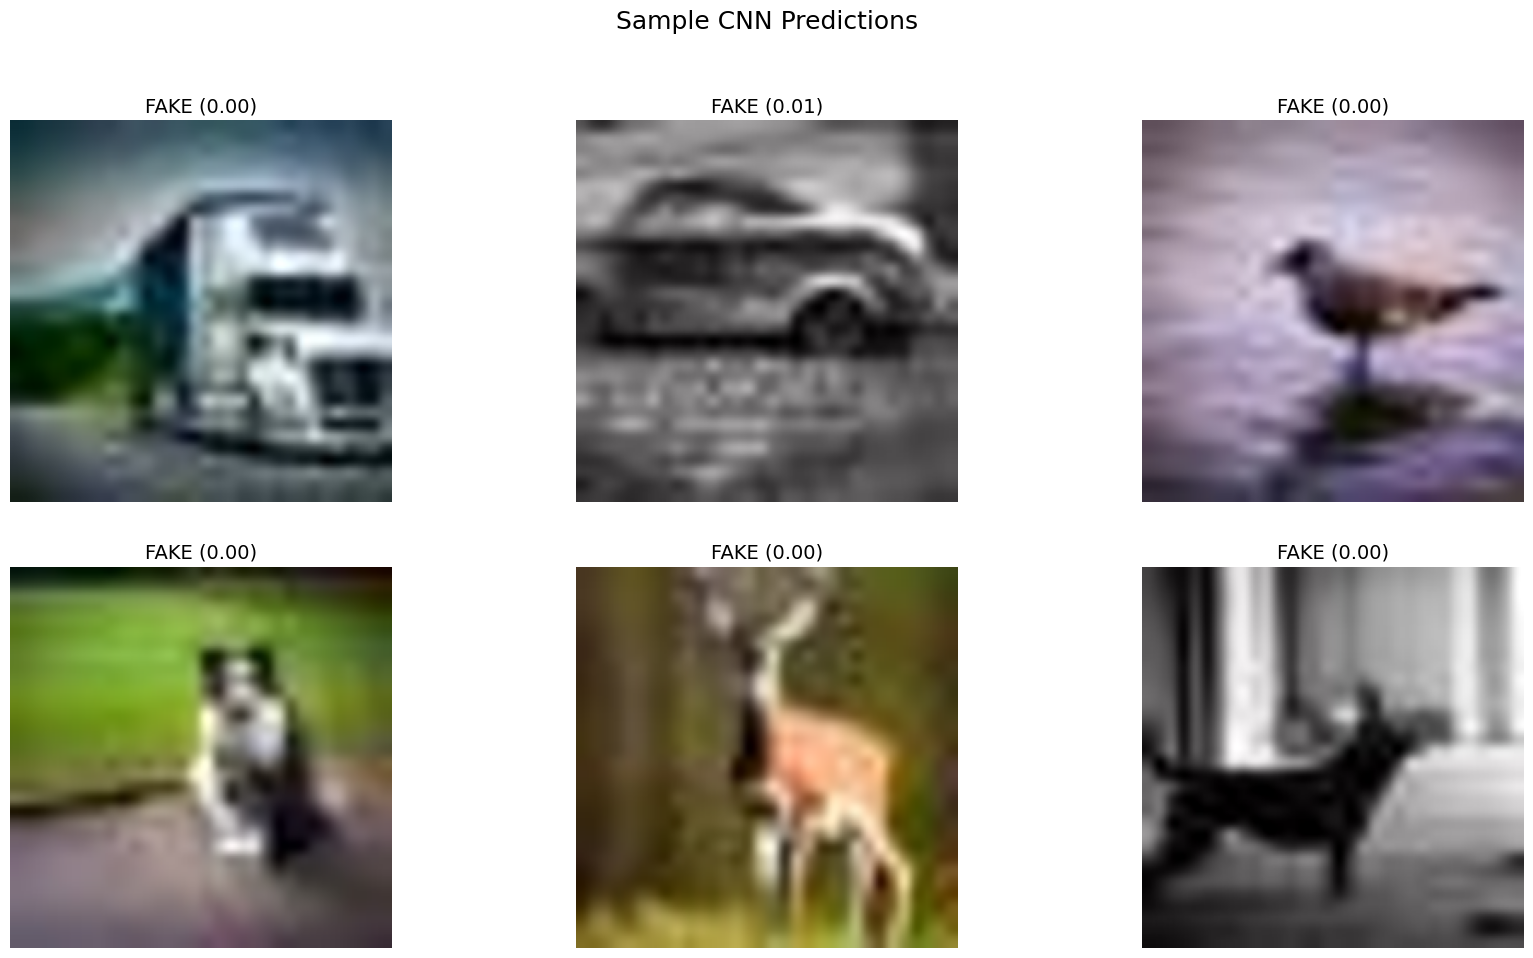

In [18]:
# ------------------------
# Plot Sample Predictions
# ------------------------
os.makedirs("results", exist_ok=True)  # ensure folder exists

plt.figure(figsize=(18,10))  # bigger canvas

for i, (img, label, score) in enumerate(samples_to_plot):
    plt.subplot(2,3,i+1)
    
    # Upscale image to 224x224 for clearer display
    img_up = img.resize((224,224), Image.BICUBIC)  # smoother interpolation
    plt.imshow(img_up)
    
    plt.title(f"{label} ({score:.2f})", fontsize=14)
    plt.axis('off')

plt.suptitle("Sample CNN Predictions", fontsize=18)
plt.tight_layout(pad=3)
plt.savefig("results/sample_predictions.png")  # saves for GitHub
plt.show()